In [172]:
import pandas as pd
import sqlite3

%pylab inline

conn = sqlite3.connect("tenders.db")

Populating the interactive namespace from numpy and matplotlib


In [173]:
ab = pd.read_sql_query("select * from aanbestedingen;", conn)
ab.publicatiedatum = pd.to_datetime(ab.publicatiedatum)
ab.aanvang_opdracht = pd.to_datetime(ab.aanvang_opdracht)
ab.sample(5)

,aanbesteding_id,naam_aanbesteding,definitieve_waarde,geraamde_waarde,publicatiedatum,aanvang_opdracht,ad_officiele_benaming,hoofdactiviteit,link
38,7687,50.10032W Realisatie bezoekzaal Detentiecentru...,NaN,0.01,2014-01-22,2012-08-18,"Rijksgebouwendienst, Expertisecentrum Aanbesteden",Huisvesting en gemeenschappelijke voorzieningen,https://www.tenderned.nl/sites/default/files//...
4999,40172,Stichting ROC Summa College,NaN,NaN,2014-05-19,NaT,Stichting ROC Summa College,Onderwijs,https://www.tenderned.nl/sites/default/files//...
11901,84071,A5.83 Stedenbouwkundige supervisie Stationsgeb...,NaN,NaN,2016-06-04,NaT,Servicepunt71,Algemene overheidsdiensten,https://www.tenderned.nl/sites/default/files//...
2575,24352,"Schoonmaakonderhoud, Glasbewassing en Sanitair...",NaN,NaN,2014-11-02,NaT,Stichting Sarkon,Onderwijs,https://www.tenderned.nl/sites/default/files//...
7838,58536,Accountantsdiensten,NaN,NaN,2015-07-31,2015-01-01,Gemeente Peel en Maas,Algemene overheidsdiensten,https://www.tenderned.nl/sites/default/files//...


In [174]:
spl = pd.read_sql_query("select * from splits;", conn)
spl.sample(5)

,split_id,aanbesteding_id,naam_gegunde_ondernemer,id_perceel,definitieve_waarde
17754,ee284394c911932bed03a2d9c16fd54e,9451,Perceel K is gegund aan: Koeman en Bijkerk in ...,5311.0,NaN
243,82bc2b27ae5d4091e5ab027d6da0ba4a,88795,Stichting Careyn (Hospice),NaN,NaN
2081,823acded3139064d9dea088b89a1c070,93598,In Harmony,41804.0,207000.0
2920,24d391182834aae38638a56cca412fda,87149,Facta Pomp- en Besturingstechniek B.V.,39872.0,1.0
4235,aa3b0f1d14646f6cb760bcdd01711017,47563,None,NaN,NaN


In [175]:
ab.join((spl.groupby(spl.aanbesteding_id).size() > 1).rename('gesplit').astype(float)).set_index("publicatiedatum").groupby(
    pd.TimeGrouper("Q")
).agg({
        "aanbesteding_id": len,
        "gesplit": lambda x: x.mean()
    })

,aanbesteding_id,gesplit
publicatiedatum,,
2013-03-31,440,0.250000
2013-06-30,521,0.250000
2013-09-30,537,0.000000
2013-12-31,702,0.166667
2014-03-31,923,0.250000
2014-06-30,849,0.120000
2014-09-30,952,0.125000
2014-12-31,1136,0.283582
2015-03-31,1260,0.221477


In [176]:
view = ab.set_index("aanbesteding_id").join((spl.groupby(spl.aanbesteding_id).size() > 1).rename('gesplit')).set_index('publicatiedatum').\
    groupby(pd.TimeGrouper("M")).agg([len, np.mean])
    
view.sample(5)

definitieve_waarde               geraamde_waarde  \
                               len          mean             len   
publicatiedatum                                                    
2015-12-31                   371.0  7.444094e+06           371.0   
2016-08-31                   154.0  8.110942e+05           154.0   
2016-01-31                   465.0  2.513695e+06           465.0   
2014-03-31                   308.0  6.158216e+06           308.0   
2013-01-31                   126.0  2.088347e+06           126.0   

                              gesplit            
                         mean     len      mean  
publicatiedatum                                  
2015-12-31       1.370536e+06     371  0.094340  
2016-08-31       5.665200e+04     154  0.084416  
2016-01-31       1.032270e+06     465  0.058065  
2014-03-31       1.431220e+06     308  0.103896  
2013-01-31       6.717667e+05     126  0.214286

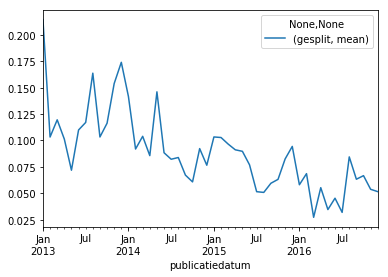

In [177]:
view[[("gesplit", "mean")]].plot()

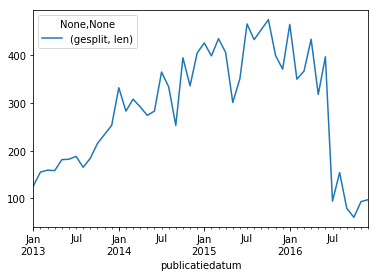

In [178]:
view[[("gesplit", "len")]].plot()

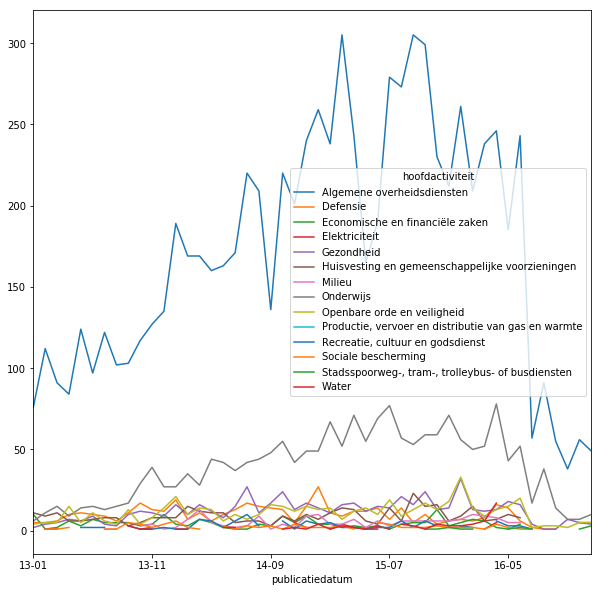

In [179]:
ab.groupby([ab.publicatiedatum.dt.strftime("%y-%m"), ab.hoofdactiviteit]).size().unstack().plot(figsize = (10, 10))

In [180]:
abp = ab.set_index("aanbesteding_id").join((spl.groupby("aanbesteding_id").size() > 1).rename("gesplit"))

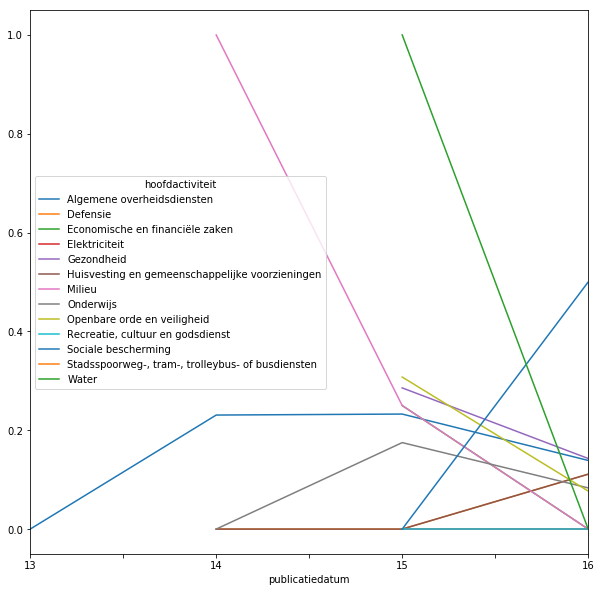

In [181]:
(abp.gesplit).groupby([ab.publicatiedatum.dt.strftime("%y"), ab.hoofdactiviteit]).apply(np.mean).unstack().plot(figsize = (10, 10))

In [182]:
quarter = ab.set_index(ab.publicatiedatum).groupby(pd.TimeGrouper('Q'))\
    .publicatiedatum.apply(lambda x: pd.Series(x.unique())).rename("qt")\
    .reset_index().rename(columns = {
        "qt": "publicatiedatum",
        "publicatiedatum": "qt"
    }).set_index('publicatiedatum').drop('level_1', axis = 1)
    
ab = ab.set_index('publicatiedatum').join(quarter).reset_index()

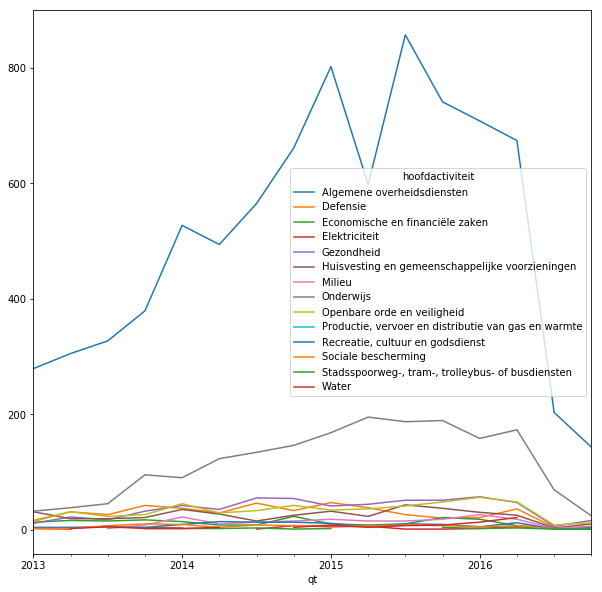

In [183]:
ab.groupby([ab.qt, ab.hoofdactiviteit]).size().unstack().plot(figsize = (10, 10))

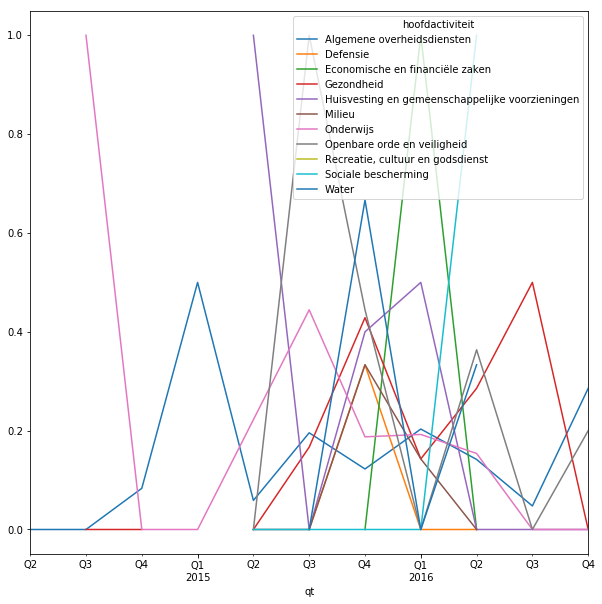

In [184]:
ab.set_index("aanbesteding_id").join(
    (spl.groupby('aanbesteding_id').size() > 1).rename("gesplit")
).groupby([ab.qt, ab.hoofdactiviteit]).gesplit.mean().unstack().plot(figsize = (10, 10))

In [189]:
ab.set_index("aanbesteding_id").join(
    (spl.groupby('aanbesteding_id').size() > 1).rename("gesplit")
).gesplit.groupby([ab.qt]).agg([len, np.sum])

,len,sum
qt,,
2014-06-30,3,1.0
2014-09-30,3,1.0
2014-12-31,17,1.0
2015-03-31,5,2.0
2015-06-30,32,4.0
2015-09-30,73,15.0
2015-12-31,189,35.0
2016-03-31,211,40.0
2016-06-30,215,32.0


In [205]:
view = spl.groupby(spl.aanbesteding_id).definitieve_waarde.agg(
    {"aantal_splits": len, "som_waarde": np.sum}
).join(ab.set_index('aanbesteding_id'), how='right')

view = view[view.som_waarde.notnull()]

/usr/share/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


In [206]:
view[view.definitieve_waarde != view.som_waarde]

,aantal_splits,som_waarde,publicatiedatum,naam_aanbesteding,definitieve_waarde,geraamde_waarde,aanvang_opdracht,ad_officiele_benaming,hoofdactiviteit,link,qt
aanbesteding_id,,,,,,,,,,,
16838,2.0,511400.00,2013-01-10,Wmo-voorzieningen gemeenten Leek en Zuidhorn,255700.00,400000.00,2013-01-10,Gemeente Leek,Algemene overheidsdiensten,https://www.tenderned.nl/sites/default/files//...,2013-03-31
10020,4.0,8296974.00,2013-01-17,Zaaknr. 31060929: het realiseren van de vereis...,1283000.00,NaN,NaT,Rijkswaterstaat Dienst Noordzee,Huisvesting en gemeenschappelijke voorzieningen,https://www.tenderned.nl/sites/default/files//...,2013-03-31
10609,2.0,221691.52,2013-01-17,Asfalt- en bodemonderzoek gemeente Eindhoven,110845.76,NaN,2013-01-01,"Gemeente Eindhoven, Sector Realisatie & Beheer",Algemene overheidsdiensten,https://www.tenderned.nl/sites/default/files//...,2013-03-31
10051,2.0,2697000.00,2013-02-13,Groenzone Zuidoost en Wolvenpolder,475000.00,NaN,NaT,Projectbureau Deltanatuur (de Provincie Zuid H...,Algemene overheidsdiensten,https://www.tenderned.nl/sites/default/files//...,2013-03-31
17132,2.0,754770.00,2013-03-09,3D digital planetarium Infoversum,239920.00,400000.00,NaT,Stichting Infoversum,Onderwijs,https://www.tenderned.nl/sites/default/files//...,2013-03-31
11924,2.0,671000.00,2013-03-22,BRM en WRM Drents Dorp Noord,267500.00,NaN,NaT,"Gemeente Eindhoven, Sector Realisatie & Beheer",Algemene overheidsdiensten,https://www.tenderned.nl/sites/default/files//...,2013-03-31
18116,4.0,1402776.00,2013-04-10,Gebouwonderhoud technisch en bouwkundig,350694.00,457500.00,NaT,Vrije Universiteit Amsterdam,Onderwijs,https://www.tenderned.nl/sites/default/files//...,2013-06-30
12901,2.0,1855654.00,2013-05-08,Zaaknr. 310.769.84: het leveren en gedurende 5...,198154.00,NaN,NaT,Rijkswaterstaat Dienst Noordzee,Huisvesting en gemeenschappelijke voorzieningen,https://www.tenderned.nl/sites/default/files//...,2013-06-30
12902,2.0,1303300.00,2013-05-28,Herinrichting Dr. Cuyperslaan,170000.00,NaN,2013-05-15,"Gemeente Eindhoven, Sector Realisatie & Beheer",Algemene overheidsdiensten,https://www.tenderned.nl/sites/default/files//...,2013-06-30


In [207]:
spl[spl.aanbesteding_id == 11924]

,split_id,aanbesteding_id,naam_gegunde_ondernemer,id_perceel,definitieve_waarde
17547,c1d17441585f7760c69d334c95f63fdd,11924,Gebr. Remmits B.V.,6483.0,267500.0
17548,e6bd4c71a8c722bd2d0326ab9b6b9d82,11924,Gebr. Remmits B.V.,6484.0,403500.0


In [208]:
ab[ab.aanbesteding_id == 11924]

,publicatiedatum,aanbesteding_id,naam_aanbesteding,definitieve_waarde,geraamde_waarde,aanvang_opdracht,ad_officiele_benaming,hoofdactiviteit,link,qt
412,2013-03-22,11924,BRM en WRM Drents Dorp Noord,267500.0,NaN,NaT,"Gemeente Eindhoven, Sector Realisatie & Beheer",Algemene overheidsdiensten,https://www.tenderned.nl/sites/default/files//...,2013-03-31


In [211]:
ab.groupby(ab.publicatiedatum.dt.year).definitieve_waarde.sum() / 1_000_000

publicatiedatum
2013     822.977106
2014    2714.397101
2015    5064.281014
2016    1282.429085
Name: definitieve_waarde, dtype: float64

In [212]:
ab.definitieve_waarde.sum()

9884084305.3600006

In [215]:
pd.options.display.max_colwidth = 500

ab.sort_values("definitieve_waarde", ascending=False)

,publicatiedatum,aanbesteding_id,naam_aanbesteding,definitieve_waarde,geraamde_waarde,aanvang_opdracht,ad_officiele_benaming,hoofdactiviteit,link,qt
6401,2015-01-26,49828,Eigendommenverzekering Gemeente Sittard-Geleen,5.791586e+08,NaN,NaT,gemeente Sittard-Geleen,Algemene overheidsdiensten,https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2015.xlsx,2015-03-31
5815,2014-12-17,10418,"Zaaknummer 31066757, SAA A9 Gaasperdammerweg (knooppunt Holendrecht-Diemen)",4.801465e+08,NaN,NaT,Rijkswaterstaat Dienst Infrastructuur,Huisvesting en gemeenschappelijke voorzieningen,https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2014.xlsx,2014-12-31
8765,2015-07-28,23671,31068466: AANKONDIGING A28/A1 KNOOPPUNT HOEVELAKEN,4.120000e+08,NaN,NaT,Rijkswaterstaat Grote Projecten en Onderhoud (GPO),Huisvesting en gemeenschappelijke voorzieningen,https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2015.xlsx,2015-09-30
10907,2015-12-23,31331,31080535: Project Zeetoegang IJmond,3.498712e+08,NaN,NaT,Rijkswaterstaat Grote Projecten en Onderhoud (GPO),Huisvesting en gemeenschappelijke voorzieningen,https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2015.xlsx,2015-12-31
12741,2016-05-20,56083,31068547: Realisatie Zuidelijke Ringweg Groningen fase 2,3.209110e+08,NaN,NaT,Rijkswaterstaat Grote Projecten en Onderhoud (GPO),Huisvesting en gemeenschappelijke voorzieningen,https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2016_Q1_Q2.xlsx,2016-06-30
6280,2015-01-16,50699,Brandverzekering ROC van Twente,3.084890e+08,NaN,NaT,ROC van Twente,Onderwijs,https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2015.xlsx,2015-03-31
4104,2014-07-14,6152,Nieuwe Huisvesting VWS / RIVM,2.668546e+08,NaN,2014-01-04,"Rijksgebouwendienst, Directie Projecten, afdeling DBFMO & Internationale Huisvesting, IPC 410",Huisvesting en gemeenschappelijke voorzieningen,https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2014.xlsx,2014-09-30
6259,2015-01-15,49816,Eigendommenverzekering gemeente Schiedam (onderwijslocaties en overige eigendommen),2.256835e+08,NaN,NaT,Gemeente Schiedam,Algemene overheidsdiensten,https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2015.xlsx,2015-03-31
5366,2014-11-06,11245,N23 Westfrisiaweg,2.059995e+08,NaN,2013-12-19,"Provincie Noord-Holland, Projectbureau N23 Westfrisiaweg",Algemene overheidsdiensten,https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2014.xlsx,2014-12-31
6402,2015-01-26,50199,Eigendommenverzekering Gemeente Kerkrade,1.948222e+08,NaN,NaT,"Gemeente Kerkrade, Raadhuis",Algemene overheidsdiensten,https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2015.xlsx,2015-03-31


In [214]:
ab[ab.naam_aanbesteding.str.contains("Eigendommen")]

,publicatiedatum,aanbesteding_id,naam_aanbesteding,definitieve_waarde,geraamde_waarde,aanvang_opdracht,ad_officiele_benaming,hoofdactiviteit,link,qt
6258,2015-01-15,49741,Eigendommenverzekering Gemeente Maassluis (on...,50651928.0,NaN,NaT,Gemeente Maassluis,Algemene overheidsdiensten,https://www.tenderned.nl/sites/default/files//...,2015-03-31
6259,2015-01-15,49816,Eigendommenverzekering gemeente Schiedam (onde...,225683496.0,NaN,NaT,Gemeente Schiedam,Algemene overheidsdiensten,https://www.tenderned.nl/sites/default/files//...,2015-03-31
6260,2015-01-15,50181,Eigendommenverzekeringen van de Gemeenten Tyt...,130534455.0,130534455.0,NaT,Gemeenten Tytsjerksteradiel en Achtkarspelen,Algemene overheidsdiensten,https://www.tenderned.nl/sites/default/files//...,2015-03-31
6282,2015-01-16,50764,Eigendommenverzekering ROC Rijn IJssel,141987642.0,NaN,NaT,Rijn IJssel,Onderwijs,https://www.tenderned.nl/sites/default/files//...,2015-03-31
6330,2015-01-20,48949,EA Eigendommenverzekering,NaN,NaN,NaT,Gemeente Almere,Algemene overheidsdiensten,https://www.tenderned.nl/sites/default/files//...,2015-03-31
6401,2015-01-26,49828,Eigendommenverzekering Gemeente Sittard-Geleen,579158601.0,NaN,NaT,gemeente Sittard-Geleen,Algemene overheidsdiensten,https://www.tenderned.nl/sites/default/files//...,2015-03-31
6402,2015-01-26,50199,Eigendommenverzekering Gemeente Kerkrade,194822174.0,NaN,NaT,"Gemeente Kerkrade, Raadhuis",Algemene overheidsdiensten,https://www.tenderned.nl/sites/default/files//...,2015-03-31
6404,2015-01-26,51238,Eigendommenverzekering Gemeente Capelle aan de...,110529507.0,NaN,NaT,Gemeente Capelle aan den IJssel,Algemene overheidsdiensten,https://www.tenderned.nl/sites/default/files//...,2015-03-31
6786,2015-02-23,51186,Eigendommenverzekering Gemeente Dalfsen,42605294.0,NaN,NaT,Gemeentehuis Dalfsen,Algemene overheidsdiensten,https://www.tenderned.nl/sites/default/files//...,2015-03-31
10311,2015-11-09,71399,Europese Openbare Aanbesteding Verzekering Ove...,797390.0,NaN,NaT,Gemeente Westland,Algemene overheidsdiensten,https://www.tenderned.nl/sites/default/files//...,2015-12-31


In [224]:
ab.groupby(ab.publicatiedatum.dt.year).size()

publicatiedatum
2013    2200
2014    3860
2015    4917
2016    2908
dtype: int64

In [240]:
ab.to_csv("./ab.csv")
spl.to_csv("./spl.csv")

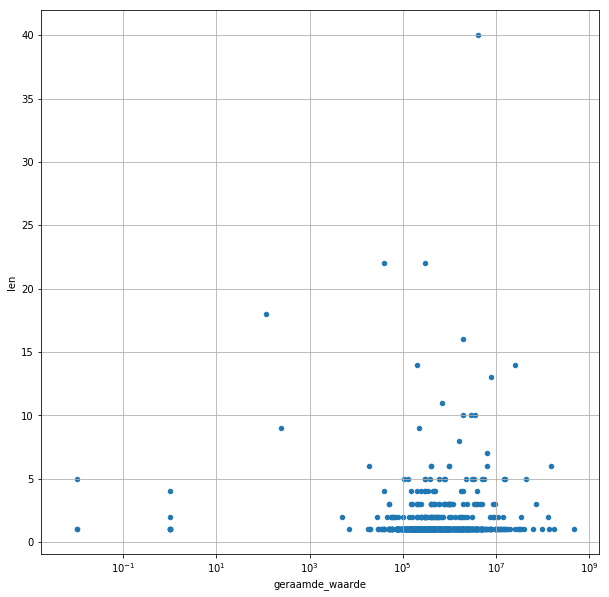

In [239]:
view = spl.groupby(spl.aanbesteding_id).definitieve_waarde.agg([len, np.sum]).join(ab.set_index('aanbesteding_id'), how='right')

# view = view[view.som_waarde.notnull()]

view.groupby(view.geraamde_waarde.round())

In [227]:
(spl.groupby(spl.naam_gegunde_ondernemer).definitieve_waarde.agg([len, sum]).sort_values('sum', ascending = False))

,len,sum
naam_gegunde_ondernemer,,
Reaal,11.0,8.331330e+08
Amlin,3.0,6.857434e+08
Combinatie Ballast Nedam Concessies B.V./ 3I BIFM lnvestments Limited/Fluor Infrastructure B.V./Heijmans Nederland B.V. (IXAS Zuid-Oost B.V. i.o),1.0,4.801465e+08
Zie bijgevoegde bijlagen,15.0,4.753000e+08
Combinatie BAM Infra B.V./BAM Infra Verkeerstechniek B.V./Van Oord Nederland B.V. (combinatie A1|A28),1.0,4.120000e+08
Achmea,5.0,3.716252e+08
Allianz,2.0,3.510943e+08
OpenIJ B.V. i.o.,1.0,3.498712e+08
Combinatie Max Bögl Nederland B.V./Züblin Nederland B.V./Oosterhof Holman Infra B.V./Koninklijke Sjouke Dijkstra B.V./Roelofs Wegenbouw B.V./]ansma Drachten B.V.,1.0,3.209110e+08
